# Installations:

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00


# Imports:

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import torch
import numpy as np

In [ ]:
import argparse
import time
from tqdm import tqdm
import copy as cp
from torch_geometric.data import Data
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import DataLoader, DataListLoader
from torch_geometric.nn import DataParallel
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GATConv

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# set the device to run on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# define the text cleaning function
def clean_text(text):
    # remove URLs and Twitter handles
    text = re.sub(r"http\S+|@\S+", "", text)
    # remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text).lower()
    # tokenize the text into words
    words = nltk.word_tokenize(text)
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # join the words back into a string
    cleaned_text = ' '.join(words)
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the inputs:

In [ ]:
print(label_map['non-rumor:767223774072676354'.strip().split(':')[0]])

1


In [ ]:
data_dirs = ['twitter15', 'twitter16']

label_file_path = 'sentiments.txt' #'label.txt'
source_tweets_file_path = 'source_tweets.txt'
tree_file_dir = 'tree'
root_path = '/content/drive/MyDrive/retweet_cascade'

num_features = 1

propagation_graph_list = []
context_graph_dict = {}
labels = []
label_dict = {}

label_rumor = {}
label_map = {"unverified": 0, "non-rumor": 1, "true": 2, "false": 3}
labels_rumor = []

for data_dir in data_dirs:
    dir_path = os.path.join(root_path, data_dir)

    with open(os.path.join(dir_path, label_file_path)) as f:
      for line in f:
        label = int(line.strip().split(':')[1])
        label_dict[line.strip().split(':')[0]] = label

    with open(os.path.join(dir_path, 'label.txt'), 'r') as file:
      for line in file:
          lab, tweet_id = line.strip().split(':')
          label_rumor[tweet_id] = label_map[lab]

    for file_name in os.listdir(os.path.join(dir_path, tree_file_dir)):
        if not file_name.endswith('.txt'):
            continue

        tweet_id = file_name[:-4]
        if len(tweet_id) > 18:
          print(tweet_id[:18])
          tweet_id = tweet_id[:18]

        node_dict = {}
        edge_list = []
        index_count = 0
        with open(os.path.join(dir_path, tree_file_dir, file_name)) as f:
            for line in f:
                parent, child = line.strip().split('->')
                parent, child = parent.replace("'", "").strip(), child.replace("'", "").strip()
                parent = parent.replace("ROOT", str(tweet_id))
                parent = int(parent.split(',')[1])
                child = int(child.split(',')[1])

                if parent not in node_dict:
                    node_dict[parent] = index_count
                    index_count += 1

                if child not in node_dict:
                    node_dict[child] = index_count
                    index_count += 1

                edge_list.append([node_dict[parent], node_dict[child]])

        y = label_dict[tweet_id]
        yy = label_rumor[tweet_id]
        labels_rumor.append(yy)
        labels.append(y)

        # features = torch.zeros((1, num_features))
        # with open(os.path.join(dir_path, source_tweets_file_path)) as f:
        #     for line in f:
        #         if line.startswith(tweet_id):
        #             cols = line.strip().split('\t')
        #             features[0, 0] = int(cols[1])  # number of followers
        #             features[0, 1] = int(cols[2])  # number of friends
        #             features[0, 2] = float(cols[3])  # ratio of followers and friends
        #             features[0, 3] = int(cols[4])  # number of history tweets
        #             features[0, 4] = int(cols[5])  # registration time (year)
        #             features[0, 5] = int(cols[6])  # whether verified account or not
        #             break
        features = torch.ones((1, num_features))

        edge_index = torch.tensor(edge_list).t().contiguous()
        x = features.repeat(len(edge_list) + 1, 1)
        data = Data(x=x, edge_index=edge_index, y=label, id=tweet_id)

        propagation_graph_list.append(data)

    with open(os.path.join(dir_path, 'source_tweets.txt')) as f:
      for line in f:
        tweet_id, tweet_text = line.strip().split('\t')

        cleaned_tweet = clean_text(tweet_text)

        inputs = tokenizer(cleaned_tweet, return_tensors='pt', truncation=True, padding=True).to(device)
        outputs = model(**inputs).last_hidden_state

        num_nodes = outputs.shape[1]  # number of words in the tweet
        node_features = outputs.squeeze(0).detach().cpu().numpy()  # word embeddings
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()  # fully-connected graph
        data = Data(x=torch.from_numpy(node_features).float(), edge_index=edge_index)

        context_graph_dict[tweet_id] = data

688096910217879554
688437279405305856
688110059553861634
688281442162352128
688441130271289350
688147918113538049
688502260779843587
688461902821855232


In [ ]:
y_list = np.array(labels)
np.save('/content/drive/MyDrive/retweet_cascade/y_list.npy', y_list)

In [ ]:
y_list = np.array(labels_rumor)
np.save('/content/drive/MyDrive/retweet_cascade/y_list_rumor.npy', y_list)

In [ ]:
print(y_list[100:700])

[3 0 3 2 0 2 3 2 3 3 0 0 0 2 0 3 3 2 3 3 3 3 2 3 2 2 3 0 3 2 3 3 3 3 2 3 0
 2 3 0 3 3 3 2 2 3 2 3 3 3 3 0 0 0 3 2 0 0 3 2 2 3 2 3 3 0 2 0 0 2 3 3 3 2
 0 2 2 3 2 0 3 2 2 2 3 2 0 2 3 3 3 3 3 0 3 2 2 3 2 0 3 2 2 2 2 3 3 0 2 2 3
 3 2 0 0 3 2 2 3 2 2 3 2 2 3 0 0 3 2 3 3 3 2 2 2 2 0 3 2 3 2 2 3 3 0 2 2 2
 2 2 2 3 3 3 2 3 3 3 0 0 2 2 3 3 3 2 2 3 0 2 3 0 3 2 3 2 0 2 3 3 0 2 2 2 2
 2 0 2 3 0 0 2 2 2 0 2 2 3 3 3 3 3 0 2 3 2 0 0 2 2 2 2 0 3 2 0 0 2 3 2 3 3
 0 3 3 0 2 3 3 3 2 0 2 2 3 3 3 0 3 2 2 3 2 3 2 2 0 2 0 2 0 2 3 3 0 0 2 3 2
 2 3 3 2 2 0 3 0 0 3 2 3 2 3 3 2 2 2 2 2 3 2 2 3 3 3 2 3 2 2 3 0 3 3 3 2 2
 2 3 3 2 3 2 2 0 2 2 3 2 3 0 2 2 2 3 0 2 2 2 0 0 3 3 0 0 3 3 2 1 0 0 3 1 0
 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 2 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0
 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1
 1 0 1 0 1 0 1 1 1 1 1 3 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 1 1 1 3 

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch.utils.data import DataLoader

context_graph_list = []
data_list = []

for graph in propagation_graph_list:
  cont = context_graph_dict[graph.id]
  context_graph_list.append(cont)

  data_list.append(Data(
      x_prop = graph.x,
      edge_index_prop = graph.edge_index,
      x_cont = cont.x,
      edge_index_cont = cont.edge_index,
      y = graph.y,
      id = int(graph.id)
      ))

class TweetGraphDataset(Dataset):
    def __init__(self, propagation_graphs, context_graph_list):
        self.propagation_graphs = propagation_graphs
        self.context_graphs = context_graph_list
        
    def __len__(self):
        return len(self.propagation_graphs)
        
    def __getitem__(self, index):
        propagation_graph = self.propagation_graphs[index]
        context_graph = self.context_graphs[index]
        return propagation_graph, context_graph

dataset = TweetGraphDataset(propagation_graph_list, context_graph_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
dataloader = DataLoader(data_list, batch_size=32, shuffle=True)
torch.save(dataloader, '/content/drive/MyDrive/retweets_loader2.pth')

In [ ]:
# torch.save(graph_list, 'retweet_cascade_dataset.pt')

# Craeting the Dataset:

In [ ]:
# from torch_geometric.data import Data

# epoch_len = 120
# land_mark_num = 18
# len = df.shape[0]-1
# overlap = 0.5
# graph_list = []
# order = []
# count = 0
# step = 10

# #edge_index, edge_attr = set_edges(epoch_len, land_mark_num)

# for i in range(1, len-epoch_len, step):
#   x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
#   data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#   graph_list.append(data)
#   count = count + 1
#   order.append((count, i))

# graph_num = count

* Saving the dataset:


In [ ]:
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

# loader = DataLoader(graph_list, batch_size=16)
# torch.save(loader, '/content/drive/MyDrive/retweets_loader.pth')

In [ ]:
# import os.path as osp

# import torch
# from torch_geometric.data import Dataset, download_url

# root = '/content/drive/MyDrive/Test_loader.pth'

# class Dataset1(Dataset):
#     def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
#         super().__init__(root, transform, pre_transform, pre_filter)

#     def len(self):
#         return len(self.processed_file_names)

#     def get(self, idx):
#         data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
#         return data

# Creating the model:

# Representation learning block:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 100

# Define the batch size for the dataloader
batch_size = 32

class Encoder1(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder1, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

class Decoder1(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder1, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class ContextAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ContextAE, self).__init__()
        self.encoder = Encoder1(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder1(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, batch):
        _, z_mean, z_log_std = self.encoder(x, edge_index, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index)
        return x_hat, z_mean, z_log_std

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

input_dim, hidden_dim, output_dim = 768, 1000, 240

dataloader = DataLoader(context_graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = ContextAE(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat, z_mean, z_log_std = model(batch.x, batch.edge_index.long(), batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(x_hat, batch.x)
        # print(loss)
        # print(kl_loss(z_mean, z_log_std))
        loss = loss + 0.1 * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(context_graph_list)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

Epoch 1/100: Loss=0.3399708867073059
Epoch 2/100: Loss=0.30594226717948914
Epoch 3/100: Loss=0.27572205662727356
Epoch 4/100: Loss=0.2728796899318695
Epoch 5/100: Loss=0.2628888487815857
Epoch 6/100: Loss=0.24702832102775574
Epoch 7/100: Loss=0.24677079916000366
Epoch 8/100: Loss=0.23996798694133759
Epoch 9/100: Loss=0.25310689210891724
Epoch 10/100: Loss=0.23860761523246765
Epoch 11/100: Loss=0.24289673566818237
Epoch 12/100: Loss=0.2468884289264679
Epoch 13/100: Loss=0.2524784207344055
Epoch 14/100: Loss=0.2519073784351349
Epoch 15/100: Loss=0.2421337068080902
Epoch 16/100: Loss=0.2394917756319046
Epoch 17/100: Loss=0.24272757768630981
Epoch 18/100: Loss=0.24628682434558868
Epoch 19/100: Loss=0.25697118043899536
Epoch 20/100: Loss=0.243623748421669
Epoch 21/100: Loss=0.22602272033691406
Epoch 22/100: Loss=0.24247007071971893
Epoch 23/100: Loss=0.24273967742919922
Epoch 24/100: Loss=0.24658086895942688
Epoch 25/100: Loss=0.23415136337280273
Epoch 26/100: Loss=0.23663316667079926
Epoch

* save the model:

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/retweet_cascade/cont_embedder_model.pt')

* embed the data:

In [ ]:
# Embed the input graphs using the trained VAE
cont_embeddings = []
cont_embedder_model = model

for graph in context_graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.batch)
    cont_embeddings.append(output[0].cpu().numpy())

In [ ]:
cont_embeddings = np.array(cont_embeddings[:,0,:])
np.save('/content/drive/MyDrive/retweet_cascade/cont_embeddings.npy', cont_embeddings)

# Do it for Prop. Grqaph list:

In [ ]:
features = torch.ones((1, 16))

for graph in propagation_graph_list:
  graph.x = features.repeat(graph.edge_index.shape[1] + 1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, PANConv, GINConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 16

# Define the batch size for the dataloader
batch_size = 32

class GCN(torch.nn.Module):
    def __init__(self, n):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(n, n)
        self.conv2 = GCNConv(n, n)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.lin(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x

class Encoder2(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(Encoder2, self).__init__()
        self.conv1 = PANConv(num_features, 64, filter_size=2, num_layers=2, aggr='mean')
        self.conv2 = GINConv(nn.Sequential(nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Linear(64, 64)))
        self.conv3 = PANConv(64, 128, filter_size=2, num_layers=2, aggr='mean')
        self.conv4 = GINConv(nn.Sequential(nn.Linear(128, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Linear(128, 128)))
        self.lin1 = torch.nn.Linear(128, 256)
        self.lin2 = torch.nn.Linear(256, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index)[0])
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index)[0])
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        z = global_mean_pool(x, batch)
        return x, z

class Decoder1(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder1, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class PropAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PropAE, self).__init__()
        self.encoder = Encoder2(input_dim, output_dim)
        self.decoder = Decoder1(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, batch):
        c, _ = self.encoder(x, edge_index, batch)
        # z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(c, edge_index)
        return x_hat

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

input_dim, hidden_dim, output_dim = 16, 128, 32

dataloader = DataLoader(propagation_graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = PropAE(input_dim, hidden_dim, output_dim).to(device)
gcn = GCN(input_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat = model(batch.x, batch.edge_index.long(), batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(gcn(x_hat, batch.edge_index), gcn(batch.x, batch.edge_index))*1000
        # print(loss)
        # print(kl_loss(z_mean, z_log_std))
        # loss = loss + 0.1 * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(propagation_graph_list)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/16: Loss=0.16464558243751526
Epoch 2/16: Loss=0.0503334142267704
Epoch 3/16: Loss=0.02587173506617546
Epoch 4/16: Loss=0.005394372623413801
Epoch 5/16: Loss=0.004891733638942242
Epoch 6/16: Loss=0.008611918427050114
Epoch 7/16: Loss=0.0036262685898691416
Epoch 8/16: Loss=0.002896232297644019
Epoch 9/16: Loss=0.0015008982736617327
Epoch 10/16: Loss=0.0008698050514794886
Epoch 11/16: Loss=0.008500090800225735
Epoch 12/16: Loss=0.0038367260713130236
Epoch 13/16: Loss=0.000786812452133745
Epoch 14/16: Loss=0.003948562778532505
Epoch 15/16: Loss=0.0006226249970495701
Epoch 16/16: Loss=0.0014486275613307953


* Save the model:

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/retweet_cascade/prop_embedder_model.pt')

embed the data:

In [ ]:
# Embed the input graphs using the trained VAE
prop_embeddings = []
prop_embedder_model = model

for graph in propagation_graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.batch)
    prop_embeddings.append(output[1].cpu().numpy())

In [ ]:
prop_embeddings = np.array(prop_embeddings[:,0,:])
np.save('/content/drive/MyDrive/retweet_cascade/prop_embeddings.npy', prop_embeddings)

* some more imports:

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool

from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid

from sklearn.metrics import f1_score

In [ ]:
class GCNSentiment(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, concat=True):
      super(GCNSentiment, self).__init__()

      self.num_features = input_dim
      self.num_classes = output_dim
      self.nhid = hidden_dim
      self.concat = concat

      self.conv1 = GATConv(self.num_features, self.nhid * 2)
      self.conv2 = GATConv(self.nhid * 2, self.nhid * 2)

      self.fc1 = Linear(self.nhid * 2, self.nhid)

      if self.concat:
        self.fc0 = Linear(self.num_features, self.nhid)
        self.fc1 = Linear(self.nhid * 2, self.nhid)
      self.fc2 = Linear(self.nhid, self.num_classes)

    def forward(self, data):
      x, edge_index, batch = data.x, data.edge_index, data.batch

      x = F.selu(self.conv1(x, edge_index))
      x = F.selu(self.conv2(x, edge_index))
      x = F.selu(global_mean_pool(x, batch))
      x = F.selu(self.fc1(x))
      x = F.dropout(x, p=0.5, training=self.training)

      if self.concat:
        news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
        news = F.relu(self.fc0(news))
        x = torch.cat([x, news], dim=1)
        x = F.relu(self.fc1(x))

      x = F.log_softmax(self.fc2(x), dim=-1)
      return x

class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CategoricalCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets):
        # inputs shape: (batch_size, num_classes)
        # targets shape: (batch_size,)
        
        # Convert targets to one-hot encoding
        targets = torch.eye(inputs.size(1))[targets].to(inputs.device)
        
        # Calculate loss
        loss = -torch.sum(targets * torch.log_softmax(inputs, dim=1), dim=1)
        
        # Average loss over batch
        loss = torch.mean(loss)
        
        return loss

def one_hot_ce_loss(outputs, targets):
    criterion = nn.CrossEntropyLoss()
    _, labels = torch.max(targets, dim=1)
    return criterion(outputs, labels)

In [ ]:
class ContextEmbedding(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ContextEmbedding, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)

        self.conv_mu = GCNConv(hidden_dim, output_dim)
        # self.lin = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, edge_index, batch):
        # x = batch.x
        # edge_index = batch.edge_index

        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv_mu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)

        return x


class PropagationEmbedding(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, concat=True):
      super(PropagationEmbedding, self).__init__()

      self.num_features = input_dim
      self.num_classes = output_dim
      self.nhid = hidden_dim
      self.concat = concat

      self.conv1 = GATConv(self.num_features, self.nhid * 2)
      self.conv2 = GATConv(self.nhid * 2, self.nhid * 2)

      self.fc1 = Linear(self.nhid * 2, self.nhid)

      if self.concat:
        self.fc0 = Linear(self.num_features, self.nhid)
        self.fc1 = Linear(self.nhid * 2, self.nhid)
      self.fc2 = Linear(self.nhid, self.num_classes)

    def forward(self, x, edge_index, batch):
      # x, edge_index, batch = data.x, data.edge_index, data.batch

      x = F.selu(self.conv1(x, edge_index))
      x = F.selu(self.conv2(x, edge_index))
      x = F.selu(global_mean_pool(x, batch))
      x = F.selu(self.fc1(x))
      x = F.dropout(x, p=0.5, training=self.training)

      if self.concat:
        news = torch.stack([data.x[(data.batch == idx).nonzero().squeeze()[0]] for idx in range(data.num_graphs)])
        news = F.relu(self.fc0(news))
        x = torch.cat([x, news], dim=1)
        x = F.relu(self.fc1(x))

      # x = F.log_softmax(self.fc2(x), dim=-1)
      return x

class AGCNSent(torch.nn.Module):
    def __init__(self, output_dim):
      super(AGCNSent, self).__init__()
      self.propagationEmb = PropagationEmbedding(1, 8, output_dim, concat=True)
      self.contextEmb = ContextEmbedding(768, 1000, output_dim)
      self.fc1 = Linear(output_dim * 2, 2*output_dim)
      self.fc2 = Linear(output_dim * 2, 3)

    def forward(self, data):
      x1 = self.propagationEmb(data.x_prop, data.edge_index_prop, data)
      x2 = self.contextEmb(data.x_cont, data.edge_index_cont, data)
      x = torch.cat([x1, x2], dim=-1)
      x = self.fc1(x)
      x = self.fc2(x)
      x = F.log_softmax(x, dim=-1)

      return x

In [ ]:
print(dataset.propagation_graphs[10])

Data(x=[120, 1], edge_index=[2, 119], y=1, id='522684367647559681')


# Training the model:

In [ ]:
from torch_geometric.data import Batch

def my_collate(batch):
    return Batch.from_data_list(batch)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 16
output_dim = 16
batch_size = 16
epoch_num = 200

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=True)
# dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=True, collate_fn=my_collate)

model = AGCNSent(output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = CategoricalCrossEntropyLoss().to(device)

model.train()
for epoch in range(epoch_num):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # for batch in dataloader:
    for batch in data_list:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch).to(device)

        m = nn.Sigmoid()

        loss = nn.CrossEntropyLoss()(out, batch.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        total_correct += (out.argmax(dim=-1) == batch.y).sum().item()
        total_samples += batch.num_graphs

    avg_loss = total_loss / 2316
    avg_acc = total_correct / total_samples

    print("Epoch ", epoch, " loss: ", avg_loss, " acc: ", avg_acc)
    #     loss.backward()
    #     optimizer.step()
    #     total_loss += loss.item()
    # print("Epoch ", epoch, " loss: ", total_loss / epoch_num) # note!


model.eval()
pred_y = []
true_y = []

for batch in dataloader:
    batch = batch.to(device)
    with torch.no_grad():
        out = model(batch)
        pred = out.argmax(dim=-1)
        pred_y.append(pred.cpu().numpy())
        true_y.append(batch.y.cpu().numpy())

pred_y = np.concatenate(pred_y, axis=0)
true_y = np.concatenate(true_y, axis=0)

f1 = f1_score(true_y, pred_y, average='macro')
print("F1 score: ", f1)

# Let's watch the model!

In [ ]:
y_list = np.load('/content/drive/MyDrive/retweet_cascade/y_list.npy')

In [ ]:
prop_embeddings = np.load('/content/drive/MyDrive/retweet_cascade/prop_embeddings.npy')
cont_embeddings = np.load('/content/drive/MyDrive/retweet_cascade/cont_embeddings.npy')

In [ ]:
feature_mat = np.concatenate((prop_embeddings, cont_embeddings), axis=1)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Load data and labels
data = feature_mat  # example input data
labels = y_list  # example labels
num_epochs = 100

# Split data into train, validation, and test sets
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.5, random_state=42)

# Define custom dataset
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)

# Create dataset and dataloaders for training, validation, and test sets
train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)
test_dataset = MyDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch [1/100], Train Loss: 0.8222, Train Acc: 59.77%, Val Loss: 0.9974, Val Acc: 48.28%
Epoch [2/100], Train Loss: 0.8253, Train Acc: 60.69%, Val Loss: 0.9992, Val Acc: 48.28%
Epoch [3/100], Train Loss: 0.8290, Train Acc: 59.29%, Val Loss: 0.9932, Val Acc: 49.14%
Epoch [4/100], Train Loss: 0.8173, Train Acc: 61.12%, Val Loss: 0.9973, Val Acc: 46.55%
Epoch [5/100], Train Loss: 0.8138, Train Acc: 61.12%, Val Loss: 1.0006, Val Acc: 46.98%
Epoch [6/100], Train Loss: 0.8145, Train Acc: 61.02%, Val Loss: 0.9962, Val Acc: 48.71%
Epoch [7/100], Train Loss: 0.8177, Train Acc: 60.48%, Val Loss: 1.0007, Val Acc: 50.00%
Epoch [8/100], Train Loss: 0.8122, Train Acc: 60.21%, Val Loss: 0.9980, Val Acc: 47.41%
Epoch [9/100], Train Loss: 0.8106, Train Acc: 60.91%, Val Loss: 1.0193, Val Acc: 46.98%
Epoch [10/100], Train Loss: 0.8154, Train Acc: 59.07%, Val Loss: 1.0199, Val Acc: 43.53%
Epoch [11/100], Train Loss: 0.8152, Train Acc: 60.42%, Val Loss: 1.0143, Val Acc: 47.41%
Epoch [12/100], Train Loss: 0.

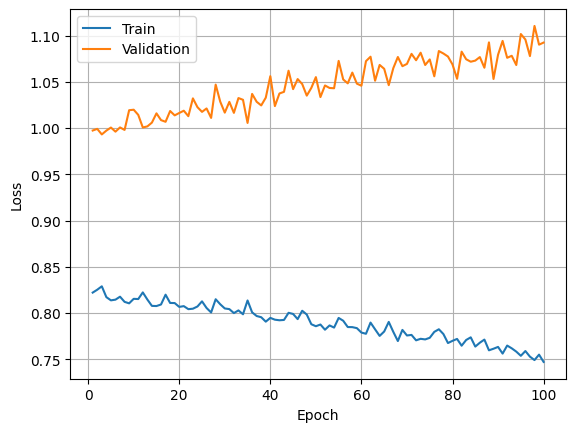

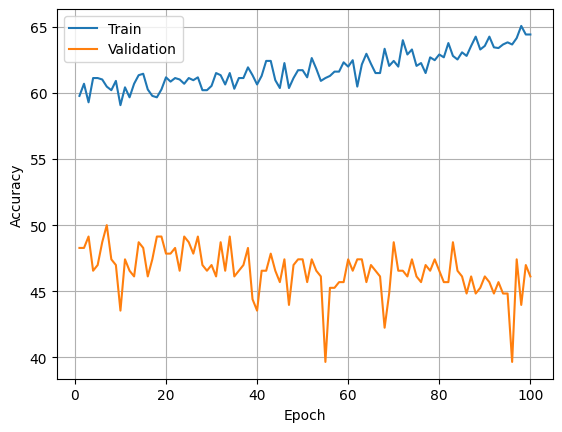

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Define DNN-based classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize model and hyperparameters
model = Classifier(input_dim=272, hidden_dim=256, output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * inputs.size(0)

    train_acc = 100.0 * train_correct / train_total
    train_loss /= len(train_loader.dataset)

    # Evaluate the model on the validation set
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)

    val_acc = 100.0 * val_correct / val_total
    val_loss /= len(val_loader.dataset)

    # Append the losses and accuracies to the lists for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Plot the losses and accuracies
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, train_accs, label='Train')
plt.plot(epochs, val_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


In [ ]:
print(predicted)

tensor([1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# Evaluate the model on the test set
test_correct = 0
test_total = 0
preds = []
labs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        for i, _ in enumerate(labels):
          preds.append(int(predicted[i]))
          labs.append(int(labels[i]))
        
test_acc = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 46.98%


In [ ]:
from sklearn.metrics import f1_score

f1_score_weighted = f1_score(labs, preds, average='weighted')
print(f1_score_weighted)

0.44456691045207913


In [ ]:
print(labs)

[1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 2, 1, 2]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize model and hyperparameters
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
model.fit(train_data, train_labels)

# Evaluate the model on the validation set
train_acc = model.score(train_data, train_labels) * 100.0
val_acc = model.score(val_data, val_labels) * 100.0
preds = model.predict(test_data)

print(f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
f1_score_weighted = f1_score(test_labels, preds, average='weighted')
print(f1_score_weighted)

Train Acc: 97.52%, Val Acc: 50.86%
0.37803762478622277


In [ ]:
from sklearn import svm

# Create SVM classifier object
clf = svm.SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(train_data, train_labels)

# Evaluate the classifier on the validation set
val_acc = clf.score(val_data, val_labels)

# Evaluate the classifier on the test set
test_acc = clf.score(test_data, test_labels)

print(f"Validation accuracy: {val_acc:.2f}, Test accuracy: {test_acc:.2f}")


Validation accuracy: 0.52, Test accuracy: 0.45
